# Explorative Datenanlyse
Hierbei sollen Zusammenhänge unter und zwischen den Daten der Schadstoffe und Predictoren ermittelt werden. Diese Erkenntnisse könnten wichtig sein um die Gründe für hohe Schadstoff-Belastungen zu entdecken und durch gezielte politische Maßnahmen gegenzusteuren.  

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from additional_functions import *
import plotly.express as ex

# General definitions
pollutans=["co","no2","so2","o3","pm2_5"]
aqi_levels={"pm2_5":[0,10,20,25,50,75],"no2":[0,40,90,120,230,340],"o3":[0,50,100,130,240,380],"so2":[0,100,200,350,500,750]}

In [2]:
'Laden der abgespeicherten Daten'
'HDF ist ein deutlich besseres Format als csv/txt/... -> Dateitypen + Index bleibt erhalten '
pollution = pd.read_hdf("Pollution_Data/pollutant_data.h5")
predictor = pd.read_hdf("Predictor_Data/all.h5",index_col=0)
predictor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7677 entries, 2000-01-01 to 2023-01-07
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PRCP                    7677 non-null   float64
 1   TMAX                    7677 non-null   float64
 2   TMIN                    7677 non-null   float64
 3   AWND                    7627 non-null   float64
 4   WSF2                    7633 non-null   float64
 5   t_minmax                7677 non-null   float64
 6   mean_temp               6530 non-null   float64
 7   max_value_temp          6530 non-null   float64
 8   max_hour_temp           6530 non-null   float64
 9   mean_humidity           6479 non-null   float64
 10  max_value_humidity      6479 non-null   float64
 11  max_hour_humidity       6479 non-null   float64
 12  mean_radiation          2670 non-null   float64
 13  max_value_radiation     2670 non-null   float64
 14  max_hour_radiation    

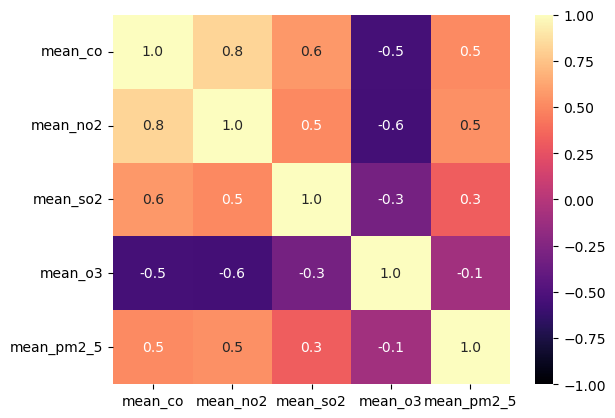

In [5]:
'Betrachtung der Correlations Matrix zwischen den Mittelwerten der Schadstoffe'
corr_mean_fig, corr_mean_ax = plt.subplots()
pollution_mean_corr=pollution[[f"mean_{i}" for i in pollutans]].corr()
corr_mean_ax = sns.heatmap(pollution_mean_corr,cmap="magma",vmin=-1,vmax=1,annot=True,fmt=".1f" )
corr_mean_fig.savefig("Visualization/EDA/Correlation_Heatmap_Mean_pollutans.png",dpi=200,bbox_inches="tight")

### Erkenntnisse der Pearson-Korrelations Matrix der Mittelwerte 
- symetrische Matrix mit dem Wert 1 auf der Hauptdiagonalen-> aufgrund der Definition 
- Die meisten Schadstoffe (außer Ozon) haben eine positive Korrelation -> dies könnte bedeuten das die Schadstoffe gemeinsame Quellen oder Abbauprozesse haben oder sich gegenseitig beeinflussen. Als Beispiel ist dabei die Verbrennung von fossilen Energien zu nennen, da diese eine gemeinsame Quelle für NO2 und CO (durch den Verbrennungsprozess) darstellt. Da insbesondere hier der Straßenverkehr auch für PM2.5 Emissionen verantwortlich ist, könnte dies eine Erklärung für die Korellation sein.
- Für Ozon lassen sich nur negative bis schwach negative Korrelationen finden, dies könnte daran liegen das die Sonneneinstrahlung für die Entstehung des Ozons verantworlich ist. 
- Verwunderlich ist die negative Korr. zw. Ozon und NO2/CO, da diese Gase Edukte bei der Entstehung von Ozon sind. 

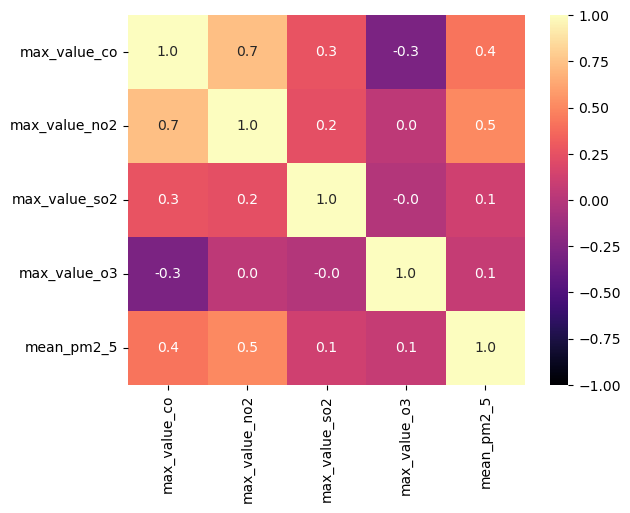

In [8]:
'correlation between the max_value of each pollutant'
corr_max_fig, corr_max_ax = plt.subplots()
columns_corr=[f"max_value_{i}" for i in pollutans[:4]]
columns_corr.append("mean_pm2_5")
pollution_max_corr=pollution[columns_corr].corr()
sns.heatmap(pollution_max_corr,cmap="magma",vmin=-1,vmax=1,annot=True,fmt=".1f" )
corr_max_fig.savefig("Visualization/EDA/Correlation_Heatmap_Max_pollutans.png",dpi=200,bbox_inches="tight")

### Korrelationen zwischen den Maxima
Bei den maximalen Werte für die Schadstoffe kann ein ähnliches Verhalten wie für die Mittelwerte beobachtete werden. Allerdings gibt es auch einige Unterschiede:
- Zu SO2 gibt es nur geringe Korr. 
- statt den negativen Werten bei Ozon zeigen sich fast keine Korrelationen.


/tmp/ipykernel_8538/2321578902.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pollution_corr=pollution.drop([f"max_hour_{i}" for i in pollutans[:4]],axis=1).corr()


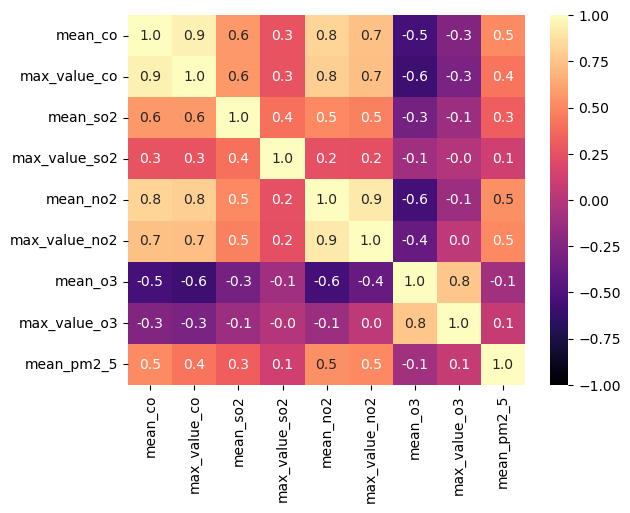

In [7]:
'Correlation between max and mean value of each pollutant'
corr_fig, corr_ax = plt.subplots()
pollution_corr=pollution.drop([f"max_hour_{i}" for i in pollutans[:4]],axis=1).corr()
sns.heatmap(pollution_corr,cmap="magma",vmin=-1,vmax=1,annot=True,fmt=".1f")
corr_fig.savefig("Visualization/EDA/Correlation_Heatmap_pollutans.png",dpi=200,bbox_inches="tight")

### Korrelation zwischen den mean und max Werten der einzelnen Schadstoffe: 
Starke Korrelation bedeuten, eine lange Lebensdauer oder die Ursache des  Schadstoffs  ist langanhaltend.
- CO 0.9
- NO2 0.9
- O3 0.7

Gering: SO2 0.2

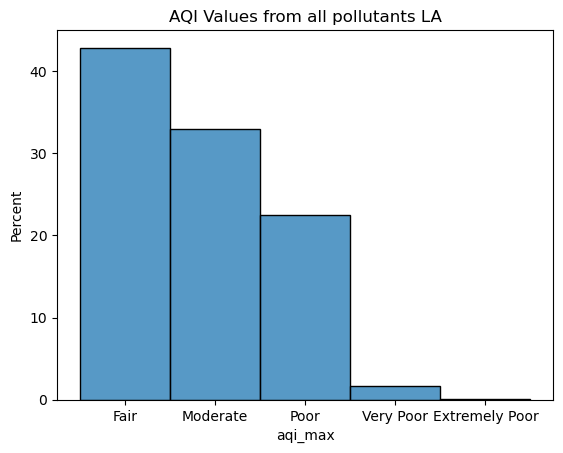

In [8]:
'Histogram of the AQI values from all pollutants'
aqi_fig, aqi_ax = plt.subplots()
sns.histplot(x=pollution["aqi_max"],stat="percent").set(title="AQI Values from all pollutants LA")
aqi_fig.savefig("Visualization/EDA/AQI.png",dpi=200,bbox_inches="tight")

<AxesSubplot: title={'center': 'Histogra_max_value_no2'}, xlabel='max_value_no2', ylabel='Percent'>

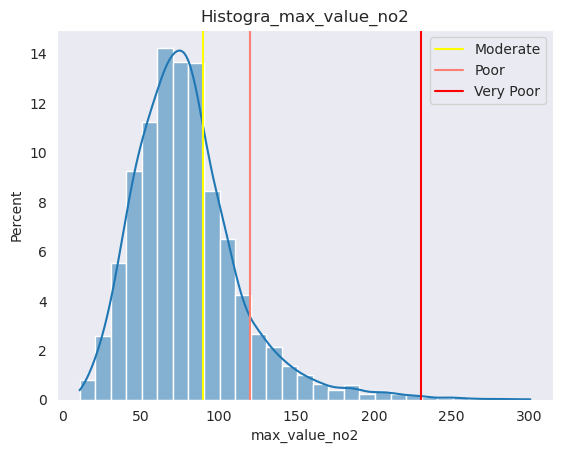

In [9]:
def pollutant_hist(pollutant,bins=5,max_value=True,show_aqi="all"):
    """ function to create a histogram of the pollutant concentration 

    Args:
        pollutant (str): name of the pollutant
        bins (int, optional): number of bins. Defaults to 5.
        max_value (bool, optional): If True the max_value of the pollutant will be used. Defaults to True.
        show_aqi (str, optional): If True the AQI-Boarder for "Poor" and "Very Poor" will be added. Defaults to "all".

    Returns:
        plt.figure: histogram
    """
    global aqi_levels
    sns.set_style("dark")
    if max_value:
        colname=f"max_value_{pollutant}"
    else:
        colname=f"mean_{pollutant}"
    fig=sns.histplot(pollution[colname],stat="percent",binwidth=bins,kde=True)
    fig.axvline(aqi_levels[pollutant][2],color="yellow",label="Moderate")
    if show_aqi=="all":
        fig.axvline(aqi_levels[pollutant][3],color="salmon",label="Poor")
        fig.axvline(aqi_levels[pollutant][4],color="red",label="Very Poor")
    fig.set_title(f"Histogram_{colname}")
    fig.legend()
    return fig

pollutant_hist("no2",bins=10)



[Text(0.5, 1.0, 'AQI Values from NO2')]

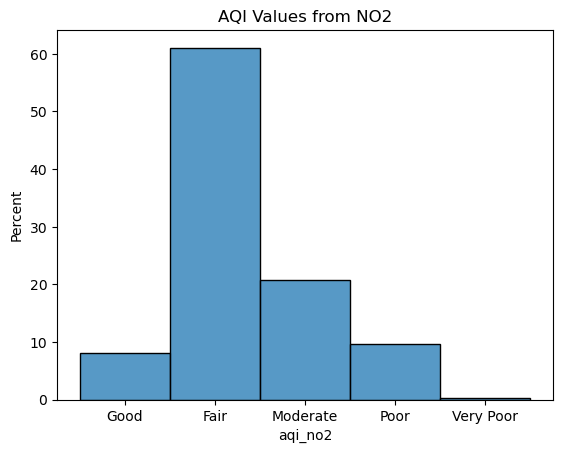

In [9]:
sns.histplot(x=pollution["aqi_no2"],stat="percent").set(title="AQI Values from NO2")

<AxesSubplot: title={'center': 'Histogra_mean_pm2_5'}, xlabel='mean_pm2_5', ylabel='Percent'>

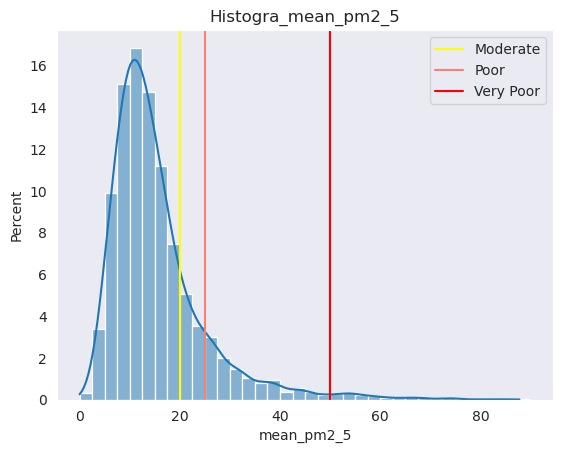

In [11]:
pollutant_hist("pm2_5",bins=2.5,max_value=False)

<AxesSubplot: xlabel='aqi_pm2_5', ylabel='Percent'>

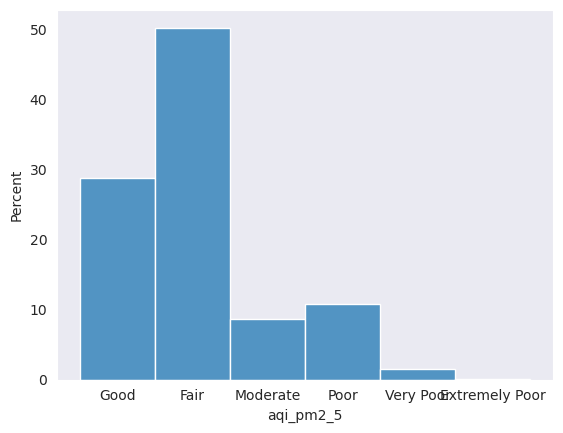

In [12]:
sns.histplot(x=pollution["aqi_pm2_5"],stat="percent").set(title="AQI Values from PM2.5")

<AxesSubplot: title={'center': 'Histogra_max_value_so2'}, xlabel='max_value_so2', ylabel='Percent'>

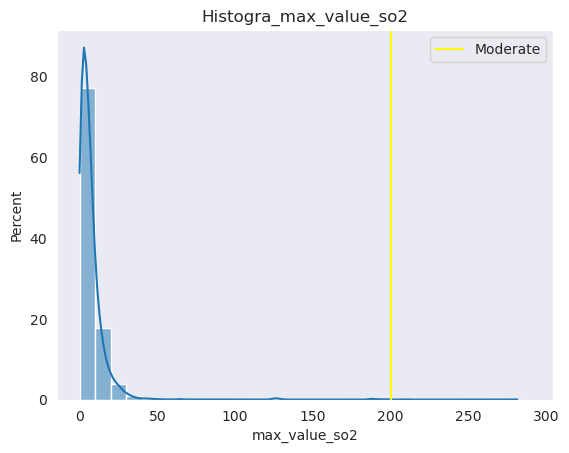

In [13]:
pollutant_hist("so2",bins=10,show_aqi="moderate")

<AxesSubplot: title={'center': 'Histogra_max_value_o3'}, xlabel='max_value_o3', ylabel='Percent'>

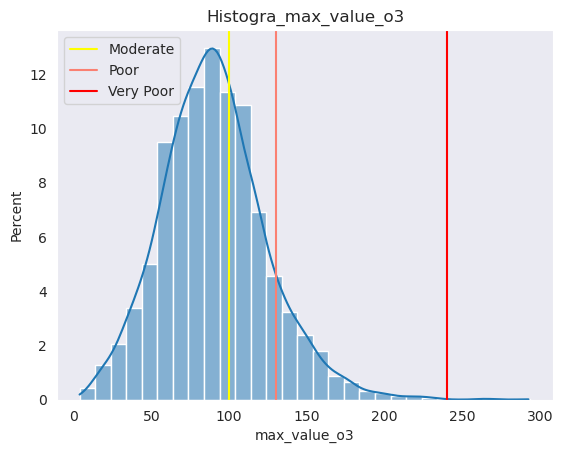

In [14]:
pollutant_hist("o3",bins=10,show_aqi="all")

<AxesSubplot: xlabel='aqi_o3', ylabel='Percent'>

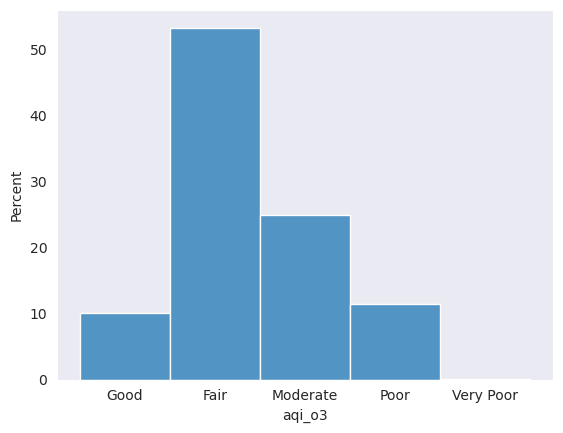

In [15]:
sns.histplot(x=pollution["aqi_o3"],stat="percent").set(title="AQI Values from O3")

Damit wird deutlich, welche der Schadstoffe in LA hauptsächlich zur Luftverschmutzung beitragen:
- **O3** mit fast 50 % Moderat und schlechter
- PM 2.5 
- NO2 mit fast 25 % Moderat und schlechter (hier nur mean Wert, da kein max verfügbar)

SO2 ist dagegen nicht relevant. Das könnte daran liegen das der Standort in Downtown LA liegt und daher wenig Industrie benachbart ist und mittlerweile überall SO2 Filter-Systeme vorhanden sind.

**Die weiter Analyse wird sich deshalb hauptsächlich mit den drei Schadstoffen beschäftigen.**

Text(0.5, 1.0, 'normalisierte Schadstoffkonzentrationen über den gesamten Zeitraum')

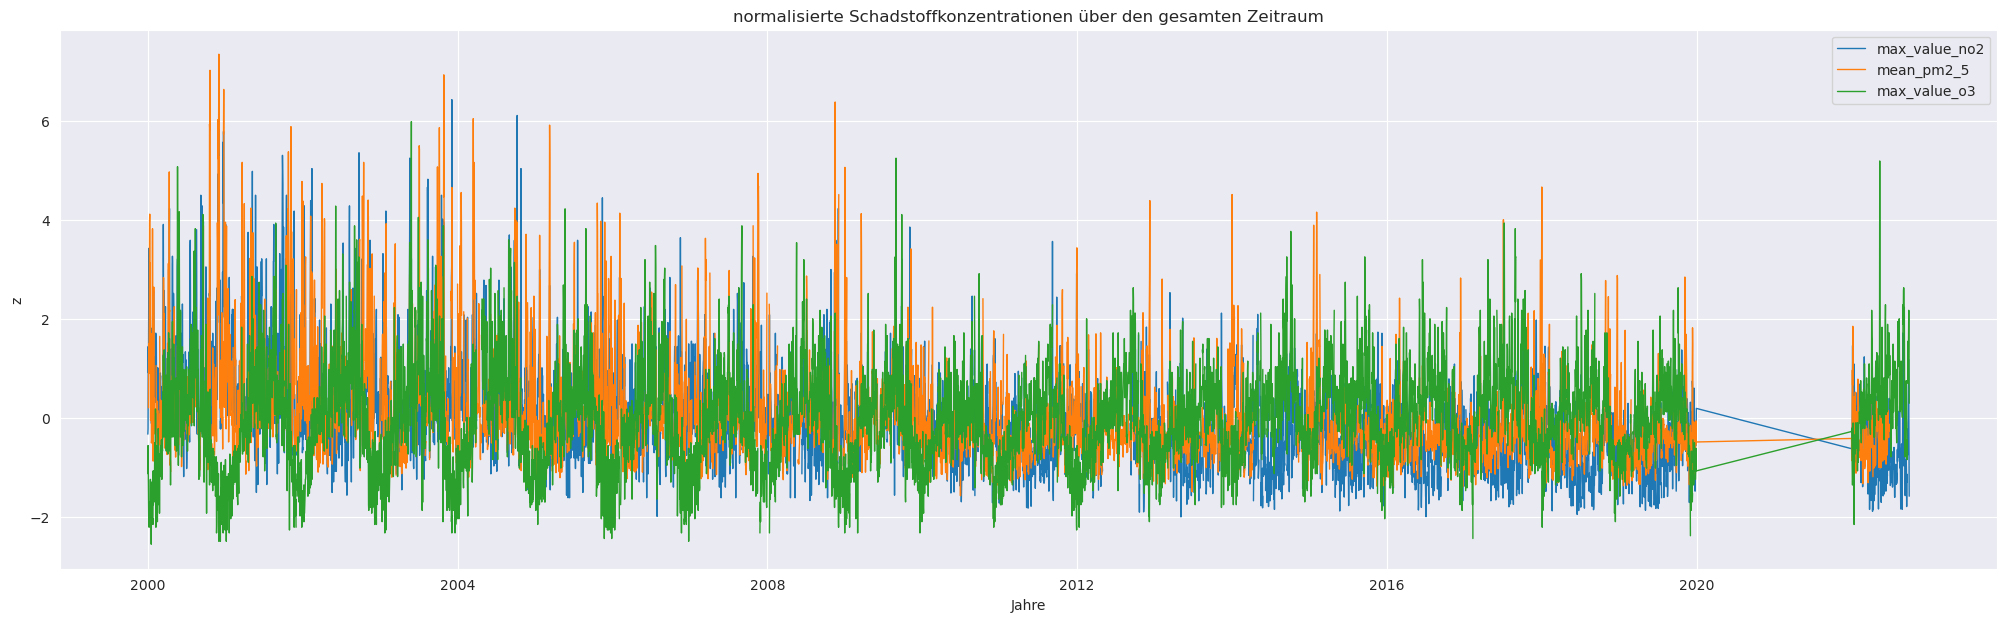

In [35]:
pollution_fig,poll_ax= plt.subplots(1,1,figsize=(25,7))

for y in ["max_value_no2","mean_pm2_5","max_value_o3"]:
    y_normalized=(pollution[y]-pollution[y].mean())/pollution[y].std()
    poll_ax.plot(pollution.index,y_normalized,label=y,lw=1)
poll_ax.legend()
poll_ax.set_ylabel("z")
poll_ax.set_xlabel("Jahre")

poll_ax.grid()
poll_ax.set_title("normalisierte Schadstoffkonzentrationen über den gesamten Zeitraum")

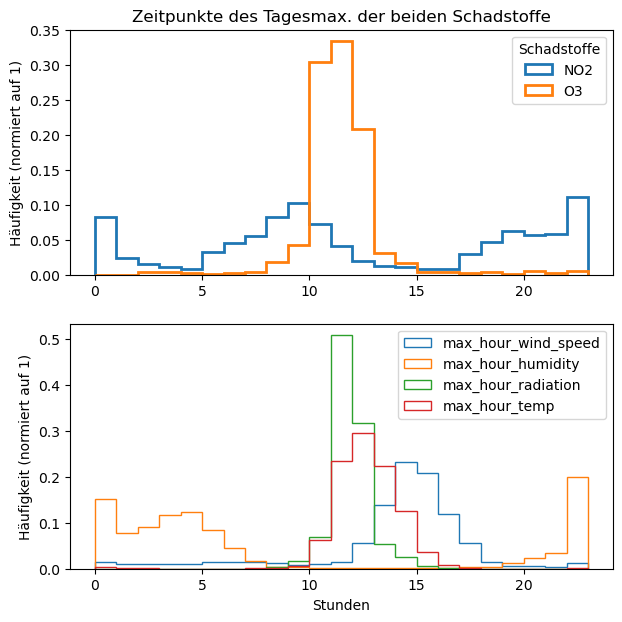

In [47]:
hour_fig, (hour_ax,pred_ax) = plt.subplots(2,1,figsize=(7,7))

hour_ax.hist(pollution["max_hour_no2"],bins=range(0,24),histtype="step",density=True,label="NO2",lw=2)
hour_ax.hist(pollution["max_hour_o3"],bins=range(0,24),histtype="step",density=True,label="O3",lw=2)
hour_ax.set_title("Zeitpunkte des Tagesmax. der beiden Schadstoffe")
hour_ax.set_ylabel("Häufigkeit (normiert auf 1)")

hour_ax.legend(title="Schadstoffe")

hour_columns=["max_hour_wind_speed","max_hour_humidity","max_hour_radiation","max_hour_temp"]
for column in hour_columns:
    pred_ax.hist(predictor[column],bins=range(0,24),histtype="step",density=True,label=column)

pred_ax.set_xlabel("Stunden")
pred_ax.set_ylabel("Häufigkeit (normiert auf 1)")

pred_ax.legend(fontsize=10)


Diese Gegenüberstellung des Zeitpunkt des maximalen Tageswertes soll mögliche Ursachen identifizieren.  
#### Ozon O3
Für Ozon kann erkannt werden das die höchste Konzentration um die Mittagszeit erreicht wird. Dies ist zum selben Zeitpunkt bei dem auch die größte Sonneneinstrahlung erkannt werden kann. Daher lässt sich an dieser Stelle vermuten, das die hohe Ozon-Konzentration durch die Sonneneinstrahlung verursacht wird, dies passt auch zum radikalischen Entstehungprozess (begünstigt durch UV-Strahlung). Jedoch lässt sich diese These mit der Graphik nicht beweisen.

#### Stickoxide NO2
Die Stickoxide zeigen kein so deutliches Verhalten wie das Ozon, stattdessen werden zwei breite Maxima am Vormittag und Abend erkannt. Dies kann nur schlecht durch einen meterologischen Parameter erklärt werden. Stattdessen verantwortlich könnten die Verbrennungsabgase des Verkehrs sein, da die Rush Hour zu den beiden Zeitpunkten passt. 

In [17]:
predictor.columns

Index(['day_of_week', 'month', 'quarter', 'year', 'business_day', 'PRCP',
       'TAVG', 'TMAX', 'TMIN', 'AWND', 'WSF2', 't_minmax', 'mean_wind_speed',
       'max_value_wind_speed', 'max_hour_wind_speed',
       'max_value_wind_direction', 'max_hour_wind_direction', 'mean_temp',
       'max_value_temp', 'max_hour_temp', 'mean_humidity',
       'max_value_humidity', 'max_hour_humidity', 'mean_radiation',
       'max_value_radiation', 'max_hour_radiation', 'mean_uv_radiation',
       'max_value_uv_radiation', 'max_hour_uv_radiation', 'mean_pressure',
       'max_value_pressure', 'max_hour_pressure', 'wind_north', 'wind_south',
       'wind_east', 'wind_west'],
      dtype='object')

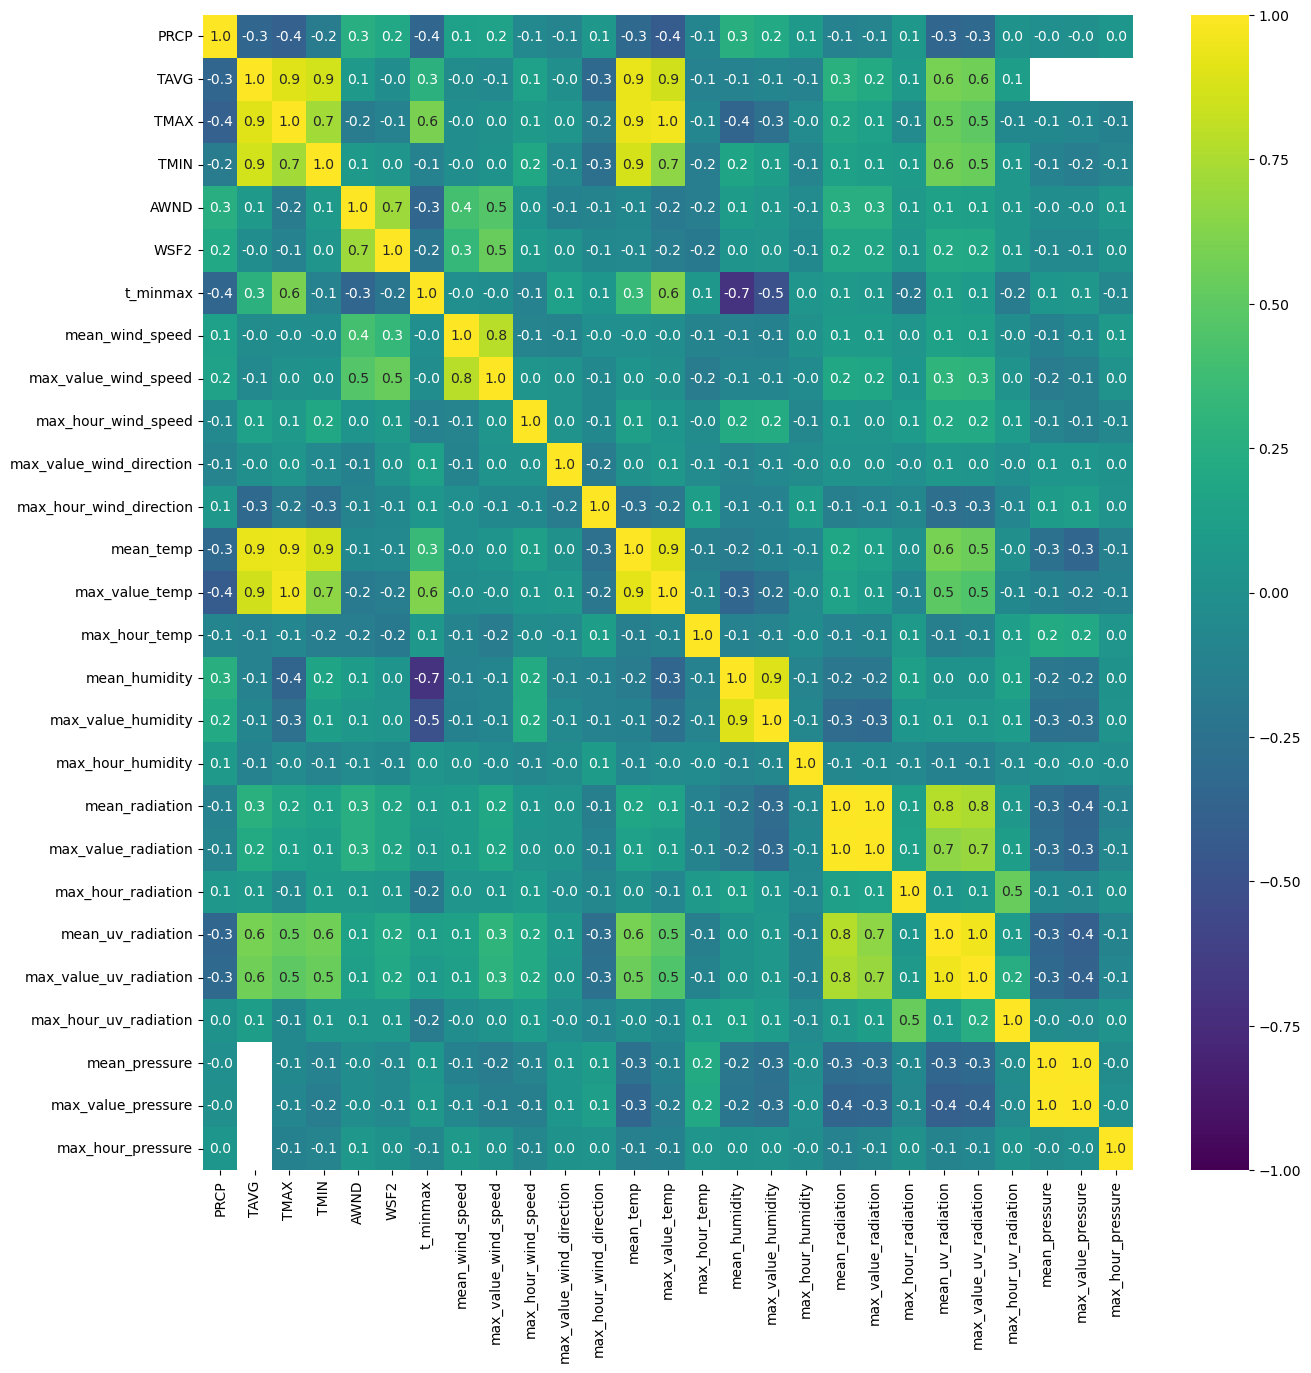

In [18]:
' ! Entfernen aller nicht Intervall/Ratioskalierten Werte d.h. z.B: Monat oder Windrichtung'
'Zählt dazu auch die Spalten mit max_hour_temp ???'
corr_fig, corr_ax = plt.subplots(figsize=(15,15))
predictor_corr=predictor[[ 'PRCP',
       'TAVG', 'TMAX', 'TMIN', 'AWND', 'WSF2', 't_minmax', 'mean_wind_speed',
       'max_value_wind_speed', 'max_hour_wind_speed',
       'max_value_wind_direction', 'max_hour_wind_direction', 'mean_temp',
       'max_value_temp', 'max_hour_temp', 'mean_humidity',
       'max_value_humidity', 'max_hour_humidity', 'mean_radiation',
       'max_value_radiation', 'max_hour_radiation', 'mean_uv_radiation',
       'max_value_uv_radiation', 'max_hour_uv_radiation', 'mean_pressure',
       'max_value_pressure', 'max_hour_pressure']].corr()
sns.heatmap(predictor_corr,cmap="viridis",vmin=-1,vmax=1,annot=True,fmt=".1f")
corr_fig.savefig("Visualization/EDA/Correlation_Heatmap_predictor.png",dpi=200,bbox_inches="tight")

In [19]:
predictor.columns

Index(['day_of_week', 'month', 'quarter', 'year', 'business_day', 'PRCP',
       'TAVG', 'TMAX', 'TMIN', 'AWND', 'WSF2', 't_minmax', 'mean_wind_speed',
       'max_value_wind_speed', 'max_hour_wind_speed',
       'max_value_wind_direction', 'max_hour_wind_direction', 'mean_temp',
       'max_value_temp', 'max_hour_temp', 'mean_humidity',
       'max_value_humidity', 'max_hour_humidity', 'mean_radiation',
       'max_value_radiation', 'max_hour_radiation', 'mean_uv_radiation',
       'max_value_uv_radiation', 'max_hour_uv_radiation', 'mean_pressure',
       'max_value_pressure', 'max_hour_pressure', 'wind_north', 'wind_south',
       'wind_east', 'wind_west'],
      dtype='object')

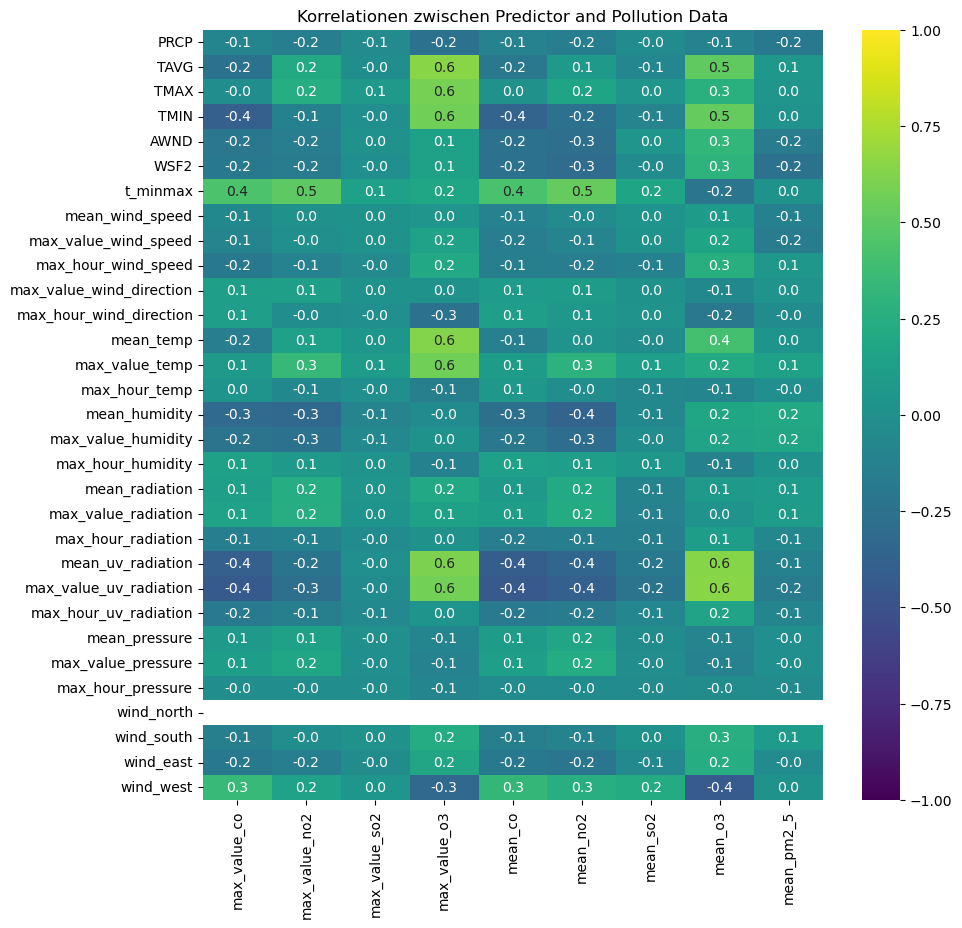

In [24]:
'Correlation zwischen den Schadstoffen und den Predictoren'
#mean wind direction ist auch dabei, da wenig Wind nach Norden dabei ist (Fehler für 0/360°)
columns_poll=[f"max_value_{i}" for i in pollutans[:4]] + [f"mean_{i}" for i in pollutans]
predictor_columns=['PRCP',
       'TAVG', 'TMAX', 'TMIN', 'AWND', 'WSF2', 't_minmax', 'mean_wind_speed',
       'max_value_wind_speed', 'max_hour_wind_speed',
       'max_value_wind_direction', 'max_hour_wind_direction', 'mean_temp',
       'max_value_temp', 'max_hour_temp', 'mean_humidity',
       'max_value_humidity', 'max_hour_humidity', 'mean_radiation',
       'max_value_radiation', 'max_hour_radiation', 'mean_uv_radiation',
       'max_value_uv_radiation', 'max_hour_uv_radiation', 'mean_pressure',
       'max_value_pressure', 'max_hour_pressure', 'wind_north', 'wind_south',
       'wind_east', 'wind_west']
mixed_corr = pd.concat([pollution[columns_poll],predictor[predictor_columns]],axis=1)
#only the correlation between predictor and pollutants
mixed_corr = mixed_corr.corr().iloc[9:,:9]

mixed_corr_fig, mixed_corr_ax = plt.subplots(figsize=(10,10))
sns.heatmap(mixed_corr,cmap="viridis",vmin=-1,vmax=1,annot=True,fmt=".1f").set(title="Korrelationen zwischen Predictor and Pollution Data")
mixed_corr_fig.savefig("Visualization/EDA/Correlation_Heatmap_mixed.png",dpi=200,bbox_inches="tight")

- Für die pm2_5 und SO2 zeigen sich nur geinge Korrelationen zwischen den Wetterdaten
  - negative Korrelation der Luftfeuchte und mean SO2 -> bildet sauren Regen, wieso dann aber nicht mit rain
- CO und NO2 zeigen beide ähnliches Verhalten (mean + max)
  - hohe Strahlung + Luftfeuchtigkeit führt zum Zerfall  
  - Temperaturunterschiede begünstigen hohe Werte -> geringer Zerfall bei niedriger Temp. ?
- O3 entsteht über radikalische Mechanismen
  - Strahlung und hohe Temp. begünstigen radik. Reaktionen


In [39]:
'PCA der predictor'
#Skalieren
pca_columns=[ 'PRCP',
        'TMAX', 'TMIN', 'AWND', 'WSF2', 't_minmax', 'mean_wind_speed',
       'max_value_wind_speed', 'max_hour_wind_speed',
       'max_value_wind_direction', 'max_hour_wind_direction', 'mean_temp',
       'max_value_temp', 'max_hour_temp', 'mean_humidity',
       'max_value_humidity', 'max_hour_humidity', 'wind_north', 'wind_south',
       'wind_east', 'wind_west']
scaler=StandardScaler()
predictor_scaled=pd.DataFrame(scaler.fit_transform(predictor[pca_columns]),index=predictor.index,columns=pca_columns)

predictor_scaled.dropna(axis=0,inplace=True)
predictor_scaled.info()

# combine df with the pollution data
predictor_combine = predictor_scaled.join(pollution.dropna(axis=0))
predictor_combine.dropna(axis=0,inplace=True)
#predictor_combine.info()

predictor_scaled = predictor_combine[predictor_scaled.columns]
#PCA
pca=PCA()
pca.fit(predictor_scaled)
# (n_samples,n_features)
predictor_pca=pca.transform(predictor_scaled)



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4479 entries, 2000-01-02 to 2019-12-31
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PRCP                      4479 non-null   float64
 1   TMAX                      4479 non-null   float64
 2   TMIN                      4479 non-null   float64
 3   AWND                      4479 non-null   float64
 4   WSF2                      4479 non-null   float64
 5   t_minmax                  4479 non-null   float64
 6   mean_wind_speed           4479 non-null   float64
 7   max_value_wind_speed      4479 non-null   float64
 8   max_hour_wind_speed       4479 non-null   float64
 9   max_value_wind_direction  4479 non-null   float64
 10  max_hour_wind_direction   4479 non-null   float64
 11  mean_temp                 4479 non-null   float64
 12  max_value_temp            4479 non-null   float64
 13  max_hour_temp             4479 non-null   flo

Text(0.5, 1.0, 'summierte erklärte Varianz der PCA')

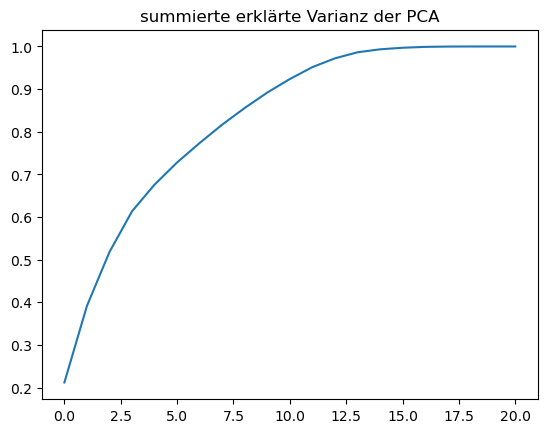

In [40]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.title("summierte erklärte Varianz der PCA")

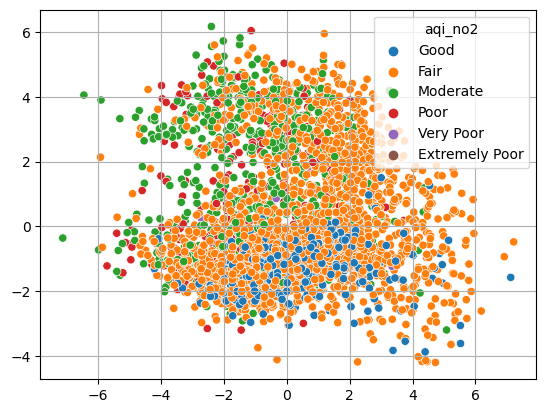

In [41]:
pca_fig, pca_ax=plt.subplots(1,1)
pca_fig = sns.scatterplot(x=predictor_pca[:,0],y=predictor_pca[:,1],hue=predictor_combine["aqi_no2"])
pca_fig.grid(True,which="major")



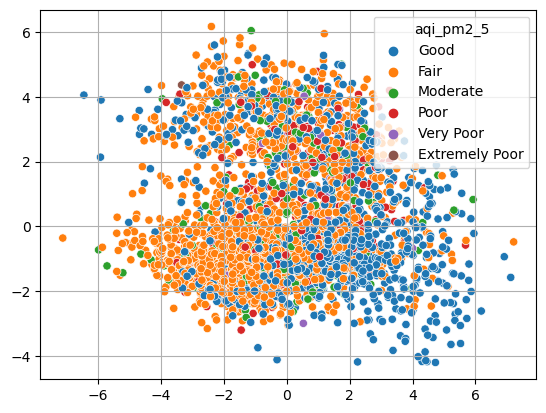

In [42]:
pca_fig, pca_ax=plt.subplots(1,1)
pca_fig = sns.scatterplot(x=predictor_pca[:,0],y=predictor_pca[:,1],hue=predictor_combine["aqi_pm2_5"])
pca_fig.grid(True,which="major")

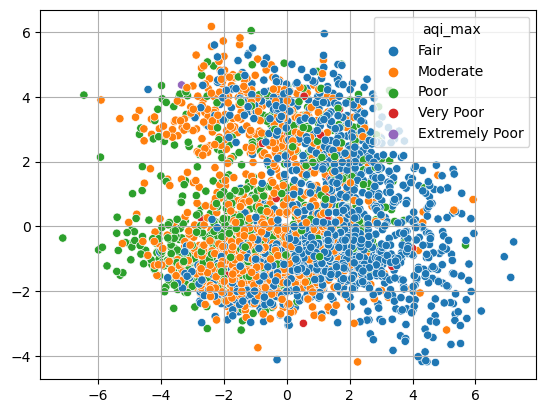

In [43]:
pca_fig, pca_ax=plt.subplots(1,1)
pca_fig = sns.scatterplot(x=predictor_pca[:,0],y=predictor_pca[:,1],hue=predictor_combine["aqi_max"])
pca_fig.grid(True,which="major")

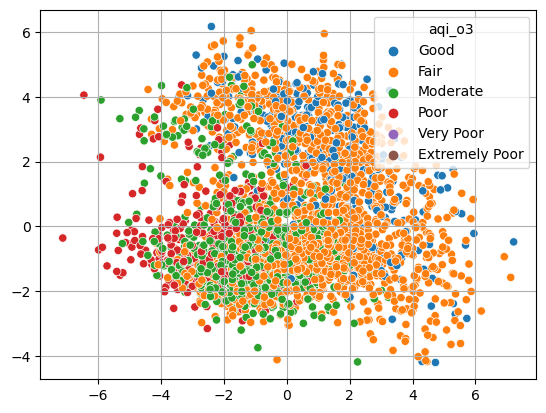

In [44]:
pca_fig, pca_ax=plt.subplots(1,1)
pca_fig = sns.scatterplot(x=predictor_pca[:,0],y=predictor_pca[:,1],hue=predictor_combine["aqi_o3"])
pca_fig.grid(True,which="major")

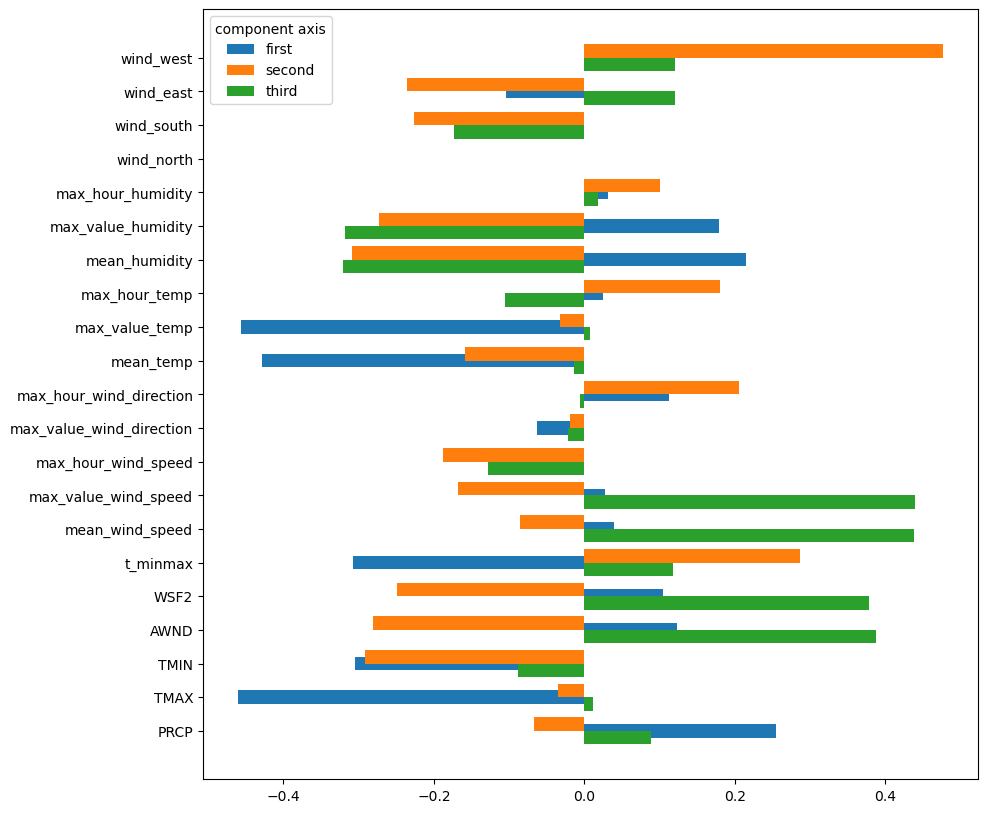

In [46]:
# pca.components_ (16,16) (n_components,n_features)
fig_comp, ax_comp = plt.subplots(1,1,figsize=(10,10))
ax_comp.barh(predictor_scaled.columns,pca.components_[0,:],height=0.4,label="first")
ax_comp.barh(predictor_scaled.columns,pca.components_[1,:],height=0.4,align="edge",label="second")
ax_comp.barh(predictor_scaled.columns,pca.components_[2,:],height=-0.4,align="edge",label="third")
ax_comp.grid(True,which="minor")
ax_comp.legend(title="component axis")

Descision Tree (Random Forest) with the categorical features

In [72]:
'Prepare Predictor'
boolean_columns=['rain_bool','business_day', 'temp_bool', 'wind_bool',
       'humidity_bool', 'radiation_bool', 'tminmax_bool']
predictor_cat=((predictor.drop(['demand_electricity', 'net_generation_electricity'],axis=1)).dropna())[boolean_columns]

wind_direction=pd.get_dummies(predictor["mean_wind_direction"])
predictor_cat = predictor_cat.join(wind_direction)
predictor_cat.columns

'Prepare Pollution'
pollution_cat=pollution[['aqi_pm2_5', 'aqi_no2', 'aqi_o3', 'aqi_max']]

'Concat to one df'
df_categorial= predictor_cat.join(pollution_cat)
df_categorial.dropna(inplace=True)
df_categorial.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1328 entries, 2015-04-01 to 2019-12-31
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   rain_bool       1328 non-null   bool    
 1   business_day    1328 non-null   bool    
 2   temp_bool       1328 non-null   bool    
 3   wind_bool       1328 non-null   bool    
 4   humidity_bool   1328 non-null   bool    
 5   radiation_bool  1328 non-null   bool    
 6   tminmax_bool    1328 non-null   bool    
 7   north           1328 non-null   uint8   
 8   south           1328 non-null   uint8   
 9   east            1328 non-null   uint8   
 10  west            1328 non-null   uint8   
 11  aqi_pm2_5       1328 non-null   category
 12  aqi_no2         1328 non-null   category
 13  aqi_o3          1328 non-null   category
 14  aqi_max         1328 non-null   category
dtypes: bool(7), category(4), uint8(4)
memory usage: 30.7 KB


In [108]:
X_train, X_test , y_train, y_test = train_test_split(df_categorial[predictor_cat.columns],df_categorial["aqi_no2"],random_state=1,stratify=df_categorial["aqi_o3"])
df_categorial["aqi_o3"].value_counts(normalize=True)

Fair              0.542169
Moderate          0.305723
Poor              0.121988
Good              0.030120
Very Poor         0.000000
Extremely Poor    0.000000
Name: aqi_o3, dtype: float64

In [109]:
rfc_cat = RandomForestClassifier(max_depth=4,min_samples_split=10)
rfc_cat.fit(X_train,y_train)

score=rfc_cat.score(X_test,y_test)
print(f"Score:{score} ")

Score:0.7289156626506024 


[Text(0.5446428571428571, 0.9, 'west <= 0.5\ngini = 0.47\nsamples = 634\nvalue = [690, 197, 103, 6]\nclass = Fair'),
 Text(0.2857142857142857, 0.7, 'rain_bool <= 0.5\ngini = 0.465\nsamples = 476\nvalue = [512, 188, 46, 2]\nclass = Fair'),
 Text(0.14285714285714285, 0.5, 'tminmax_bool <= 0.5\ngini = 0.462\nsamples = 442\nvalue = [478, 167, 46, 2]\nclass = Fair'),
 Text(0.07142857142857142, 0.3, 'east <= 0.5\ngini = 0.474\nsamples = 278\nvalue = [269, 159, 3, 0]\nclass = Fair'),
 Text(0.03571428571428571, 0.1, 'gini = 0.438\nsamples = 209\nvalue = [223, 100, 3, 0]\nclass = Fair'),
 Text(0.10714285714285714, 0.1, 'gini = 0.492\nsamples = 69\nvalue = [46, 59, 0, 0]\nclass = Good'),
 Text(0.21428571428571427, 0.3, 'humidity_bool <= 0.5\ngini = 0.336\nsamples = 164\nvalue = [209, 8, 43, 2]\nclass = Fair'),
 Text(0.17857142857142858, 0.1, 'gini = 0.392\nsamples = 101\nvalue = [118, 1, 38, 2]\nclass = Fair'),
 Text(0.25, 0.1, 'gini = 0.212\nsamples = 63\nvalue = [91, 7, 5, 0]\nclass = Fair'),


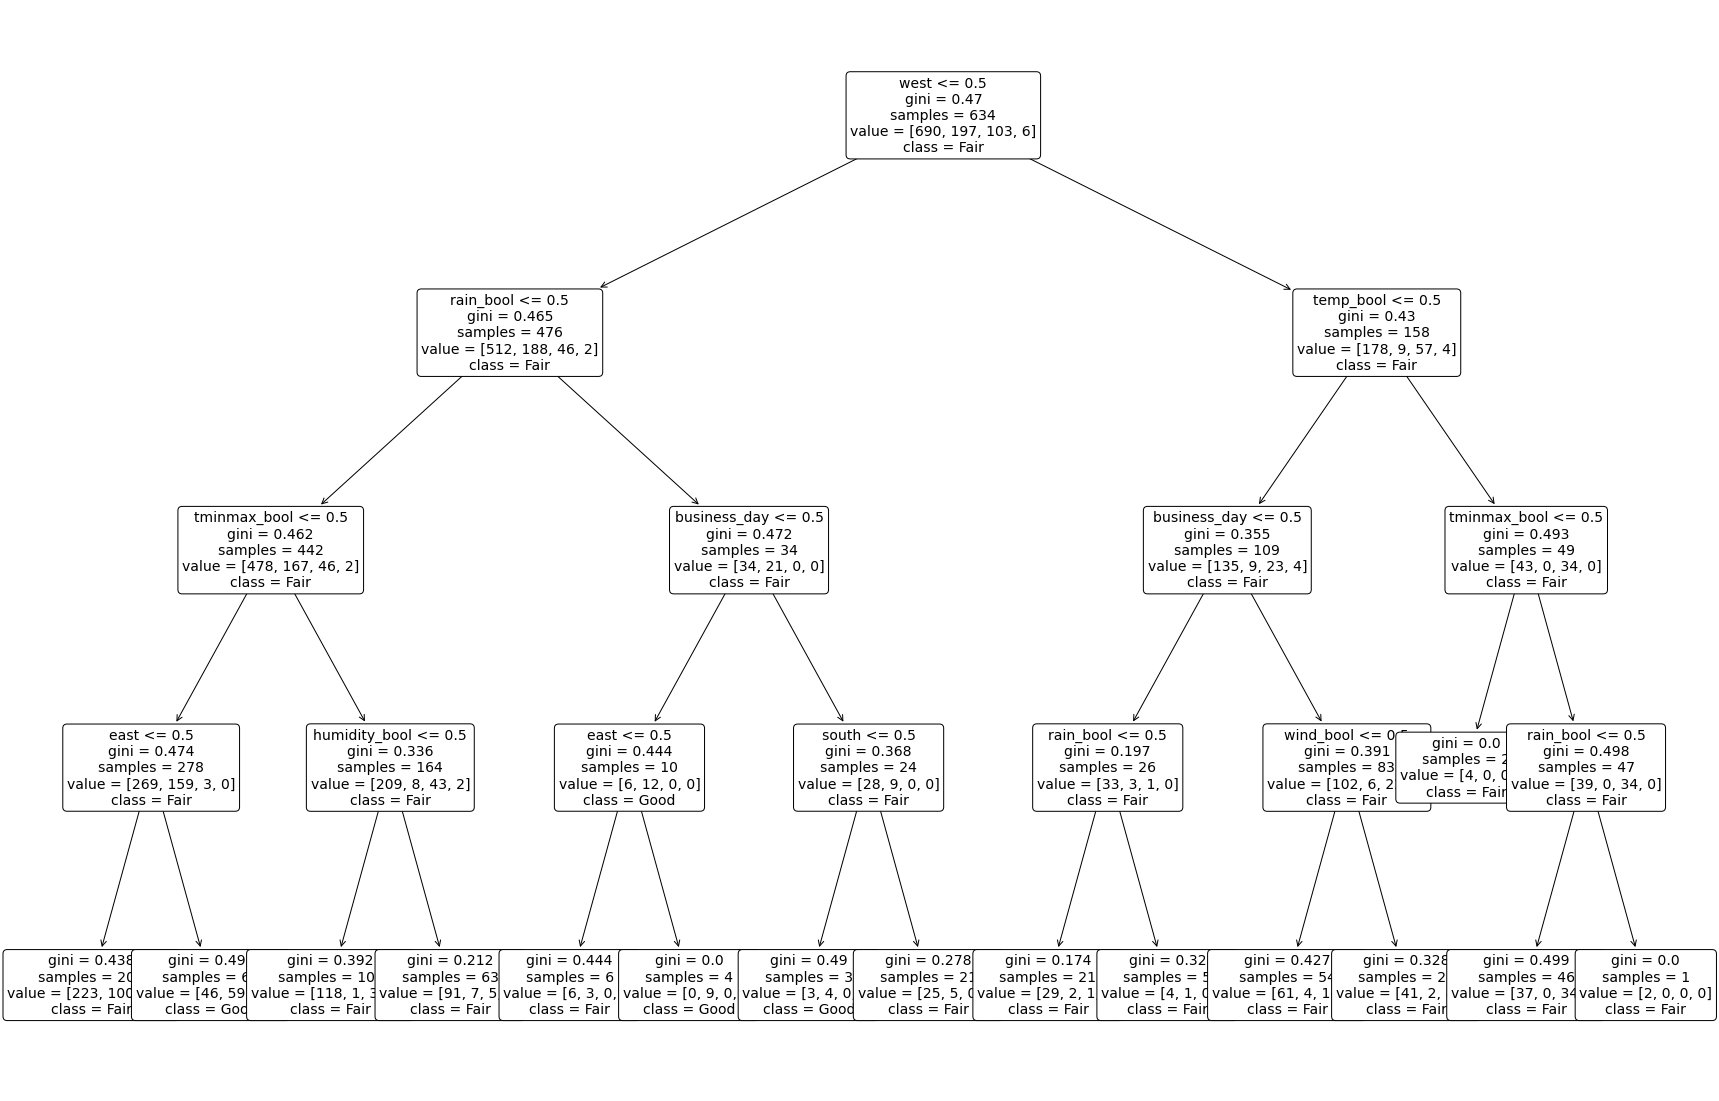

In [110]:
fig= plt.figure(figsize=(30,20))
plot_tree(rfc_cat.estimators_[0],max_depth=4,feature_names=rfc_cat.feature_names_in_,rounded=True,fontsize=14,class_names=rfc_cat.classes_)

RandomForestClassif. mit normalen Daten

In [111]:
predictor.columns

Index(['mean_wind_speed', 'max_value_wind_speed', 'max_hour_wind_speed',
       'mean_wind_direction', 'max_value_wind_direction',
       'max_hour_wind_direction', 'mean_temp', 'max_value_temp',
       'max_hour_temp', 'mean_humidity', 'max_value_humidity',
       'max_hour_humidity', 'mean_radiation', 'max_value_radiation',
       'max_hour_radiation', 'mean_uv_radiation', 'max_value_uv_radiation',
       'max_hour_uv_radiation', 'mean_pressure', 'max_value_pressure',
       'max_hour_pressure', 'rain', 't_max', 't_min', 'rain_bool', 't_minmax',
       'demand_electricity', 'net_generation_electricity', 'day_of_week',
       'month', 'quarter', 'year', 'business_day', 'temp_bool', 'wind_bool',
       'humidity_bool', 'radiation_bool', 'tminmax_bool'],
      dtype='object')

In [115]:
'Prepare Predictor'
relevant_col=['mean_wind_speed', 
       'mean_wind_direction', 
       'max_hour_wind_direction', 'mean_temp', 'max_value_temp',
       'max_hour_temp', 'mean_humidity', 'max_value_humidity',
       'max_hour_humidity', 'mean_radiation', 'max_value_radiation',
       'max_hour_radiation',
        'mean_pressure', 
        'rain', 't_max', 't_min', 't_minmax',
       'demand_electricity', 'net_generation_electricity', 'business_day',]
predictor_rf=predictor[relevant_col]

wind_direction=pd.get_dummies(predictor["mean_wind_direction"])
predictor_rf = predictor_rf.join(wind_direction)
predictor_rf.columns

'Prepare Pollution'
pollution_rf=pollution[['aqi_pm2_5', 'aqi_no2', 'aqi_o3', 'aqi_max']]

'Concat to one df'
df_rf= predictor_rf.join(pollution_rf)
df_rf.dropna(inplace=True)
df_rf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1236 entries, 2016-04-01 to 2019-12-31
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   mean_wind_speed             1236 non-null   float64 
 1   mean_wind_direction         1236 non-null   category
 2   max_hour_wind_direction     1236 non-null   float64 
 3   mean_temp                   1236 non-null   float64 
 4   max_value_temp              1236 non-null   float64 
 5   max_hour_temp               1236 non-null   float64 
 6   mean_humidity               1236 non-null   float64 
 7   max_value_humidity          1236 non-null   float64 
 8   max_hour_humidity           1236 non-null   float64 
 9   mean_radiation              1236 non-null   float64 
 10  max_value_radiation         1236 non-null   float64 
 11  max_hour_radiation          1236 non-null   float64 
 12  mean_pressure               1236 non-null   float64 
 13  

In [119]:
column_classify="aqi_no2"
X_train, X_test , y_train, y_test = train_test_split(df_categorial[predictor_cat.columns],df_categorial[column_classify],random_state=1,stratify=df_categorial[column_classify])
df_categorial[column_classify].value_counts(normalize=True)


Fair              0.699548
Good              0.188253
Moderate          0.105422
Poor              0.006777
Very Poor         0.000000
Extremely Poor    0.000000
Name: aqi_no2, dtype: float64

In [120]:
rfc = RandomForestClassifier(max_depth=200,min_samples_split=10)
rfc.fit(X_train,y_train)

score=rfc.score(X_test,y_test)
print(f"Score:{score} ")

Score:0.7018072289156626 


[Text(0.5214285714285715, 0.9166666666666666, 'tminmax_bool <= 0.5\ngini = 0.409\nsamples = 636\nvalue = [745, 150, 95, 6]\nclass = Fair'),
 Text(0.25, 0.75, 'business_day <= 0.5\ngini = 0.407\nsamples = 352\nvalue = [398, 145, 7, 0]\nclass = Fair'),
 Text(0.11428571428571428, 0.5833333333333334, 'west <= 0.5\ngini = 0.498\nsamples = 87\nvalue = [70, 61, 0, 0]\nclass = Fair'),
 Text(0.05714285714285714, 0.4166666666666667, 'humidity_bool <= 0.5\ngini = 0.497\nsamples = 75\nvalue = [51, 60, 0, 0]\nclass = Good'),
 Text(0.02857142857142857, 0.25, 'gini = 0.278\nsamples = 5\nvalue = [5, 1, 0, 0]\nclass = Fair'),
 Text(0.08571428571428572, 0.25, 'wind_bool <= 0.5\ngini = 0.492\nsamples = 70\nvalue = [46, 59, 0, 0]\nclass = Good'),
 Text(0.05714285714285714, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.11428571428571428, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.17142857142857143, 0.4166666666666667, 'rain_bool <= 0.5\ngini = 0.095\nsamples = 12\nvalue = [19, 1, 0, 0]\nclass = Fair')

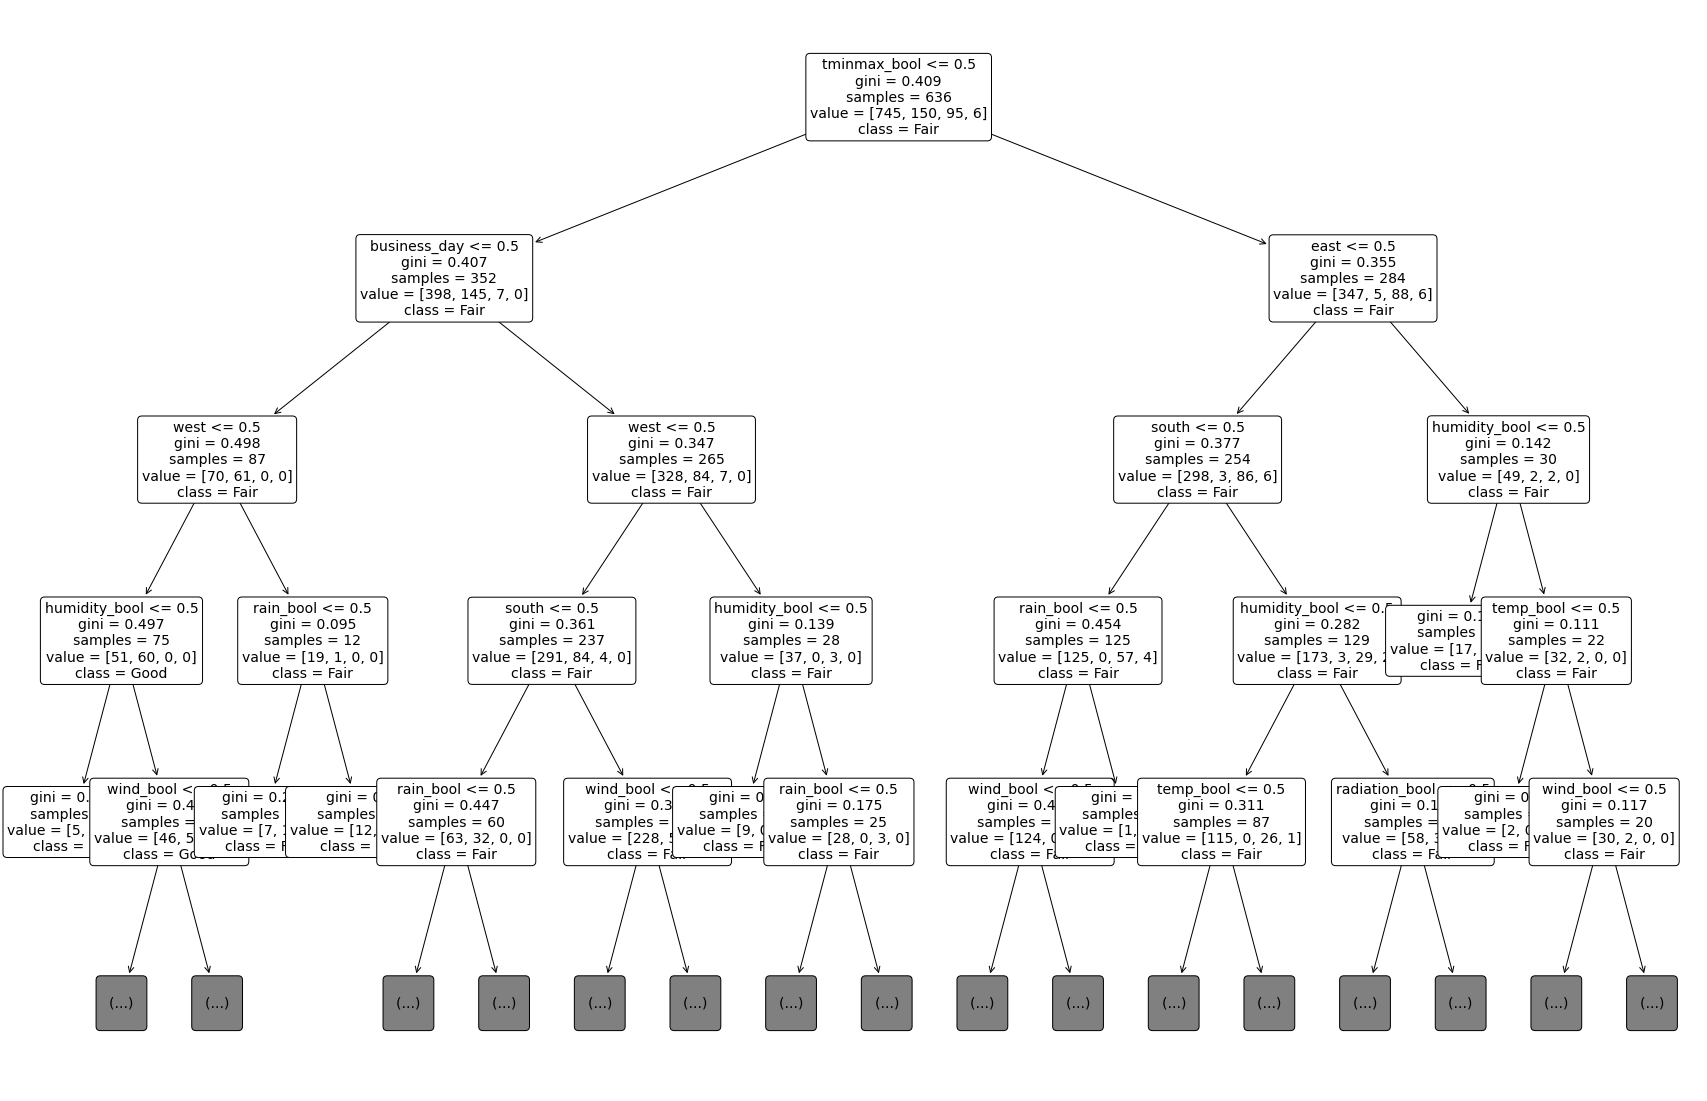

In [121]:
fig= plt.figure(figsize=(30,20))
plot_tree(rfc.estimators_[0],max_depth=4,feature_names=rfc.feature_names_in_,rounded=True,fontsize=14,class_names=rfc.classes_)